<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Simple ergonomics indicator

- box-chest distance
- box inclination
- hip-floor distance

In [105]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Markers3d, Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
)

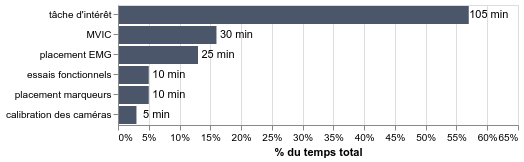

In [147]:
t = pd.DataFrame(
    {
        "tâche": [
            "tâche d'intérêt",
            "MVIC",
            "placement EMG",
            "placement marqueurs",
            "essais fonctionnels",
            "calibration des caméras",
        ],
        "durée": [105, 30, 25, 10, 10, 5],
        "% du temps total": [0.57, 0.16, 0.13, 0.05, 0.05, 0.03],
    }
)
t["durée"] = t["durée"].astype(str) + " min"

base = alt.Chart(t).encode(
    alt.X(
        "% du temps total", axis=alt.Axis(format="%"), scale=alt.Scale(domain=[0, 0.65])
    ),
    alt.Y(
        "tâche",
        title=None,
        sort=alt.EncodingSortField("% du temps total", order="descending"),
    ),
)

bars = base.mark_bar(color="#4C566A").encode()

text = base.mark_text(dx=20, color="black").encode(text=alt.Text("durée"))

bars + text

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Box-chest distance

In [4]:
box_markers = [
    "boite_avant_gauche_X",
    "boite_avant_gauche_Y",
    "boite_avant_gauche_Z",
    "boite_avant_droit_X",
    "boite_avant_droit_Y",
    "boite_avant_droit_Z",
    "boite_arriere_droit_X",
    "boite_arriere_droit_Y",
    "boite_arriere_droit_Z",
    "boite_arriere_gauche_X",
    "boite_arriere_gauche_Y",
    "boite_arriere_gauche_Z",
]


def box_thorax_distance(x):
    box = pd.concat(
        [x[box_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y", "Z"]],
        axis=1,
    )
    thorax = x.filter(like="XIPH").rename(columns=lambda x: x.replace("XIPH_", ""))
    return (
        np.sqrt(((box - thorax) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("box_thorax")
        .to_frame()
    )

In [5]:
box_thorax = (
    pd.concat(
        [
            Markers3d.from_trc(ifile)
            .time_normalization()
            .to_dataframe()
            .pipe(box_thorax_distance)
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

In [6]:
box_thorax.head()

,index,box_thorax,filename,participant,men,height,mass,n_trial
0,0.00,398.929647,VerCF6H2_1,verc,0,2,6,1
1,0.01,399.200758,VerCF6H2_1,verc,0,2,6,1
2,0.02,399.555870,VerCF6H2_1,verc,0,2,6,1
3,0.03,399.510908,VerCF6H2_1,verc,0,2,6,1
4,0.04,398.680597,VerCF6H2_1,verc,0,2,6,1


### Balance dataset

By randomly taking the minimum number of trials for each condition

In [7]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_thorax)

Initial
n. participants: 40
----------
men
0    114
1    126
----------
height
2    240
----------
mass
6     120
12    120
----------
men  mass
0    6       57
     12      57
1    6       63
     12      63
----------


In [8]:
balanced_trials = random_balanced_design(
    box_thorax, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_thorax = box_thorax.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_thorax)

Balanced:
n. participants: 40
----------
men
0    114
1    114
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       57
     12      57
1    6       57
     12      57
----------


### Stats

In [9]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_thorax.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_thorax              \
index                                                  0.00        0.01   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        398.929647  399.200758   
VerCF12H2_2 37          0   2      12   2        485.814111  485.083448   
VerCF12H2_1 37          0   2      12   1        469.037282  468.574571   
VerCF12H2_3 37          0   2      12   3        418.438953  418.669229   
VerCF6H2_2  37          0   2      6    2        482.462982  483.432013   

                                                                         \
index                                                  0.02        0.03   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        399.555870  399.510908   
VerCF12H2_2 37          0   2      12   2        484.243544  483.622022   
VerCF12H2_1 37          0   2      12   1        467.872527  467.212605   
VerCF12H2_3 37          0   2      12   3        419.123709  419.624171   
VerCF6H2_2  37          0   2      6    2        483.940327  484.137037   

                                                                         \
index                                                  0.04        0.05   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        398.680597  396.926207   
VerCF12H2_2 37          0   2      12   2        483.406298  483.056056   
VerCF12H2_1 37          0   2      12   1        466.301037  465.158769   
VerCF12H2_3 37          0   2      12   3        420.003305  420.343762   
VerCF6H2_2  37          0   2      6    2        484.260796  483.826338   

                                                                         \
index                                                  0.06        0.07   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        396.363720  397.888476   
VerCF12H2_2 37          0   2      12   2        482.206439  482.172174   
VerCF12H2_1 37          0   2      12   1        463.127638  460.440200   
VerCF12H2_3 37          0   2      12   3        420.271482  419.925326   
VerCF6H2_2  37          0   2      6    2        483.173583  482.147577   

                                                                         ...  \
index                                                  0.08        0.09  ...   
filename    participant men height mass n_trial                          ...   
VerCF6H2_1  37          0   2      6    1        399.912202  402.117511  ...   
VerCF12H2_2 37          0   2      12   2        482.446045  482.498937  ...   
VerCF12H2_1 37          0   2      12   1        458.801441  458.373183  ...   
VerCF12H2_3 37          0   2      12   3        419.625136  418.701297  ...   
VerCF6H2_2  37          0   2      6    2        480.551255  478.538660  ...   

                                                                         \
index                                                  0.91        0.92   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        654.085187  658.046031   
VerCF12H2_2 37          0   2      12   2        676.484743  682.174806   
VerCF12H2_1 37          0   2      12   1        680.408616  681.854813   
VerCF12H2_3 37          0   2      12   3        679.541259  684.396388   
VerCF6H2_2  37          0   2      6    2        686.902215  689.553326   

                                                                         \
index                                                  0.93        0.94   
filename    participant men height mass n_trial                           
VerCF6H2_1  37          0   2      6    1        660.436820  662.413649   
VerCF12H2_2 37          0   2      12   2        686.262649  687.519793   
VerCF12H2_1 37          0   

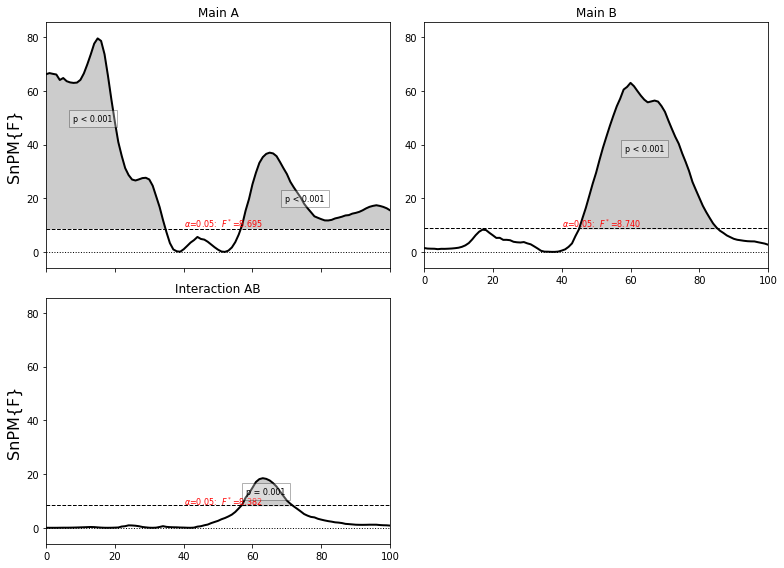

In [10]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [11]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0,0,0.343561
1,main sex,0,0.56062,0.990099
2,main mass,0,0.446442,0.844356
3,interaction sex-mass,0.000666667,0.562853,0.708734


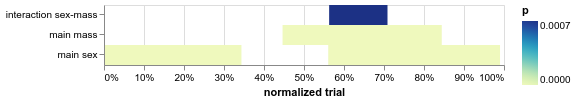

In [12]:
alt.Chart(clusters).mark_rect().encode(
    alt.X("start", title="normalized trial", axis=alt.Axis(format="%")),
    alt.X2("end"),
    alt.Y("effect:N", title=None),
    alt.Color("p:Q"),
)

In [13]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [14]:
base = alt.Chart(box_thorax).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(
    alt.Y("mean(box_thorax)", title="box-thorax distance (mm)")
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("box_thorax", title=None))
men_scale = alt.Scale(scheme="set1")

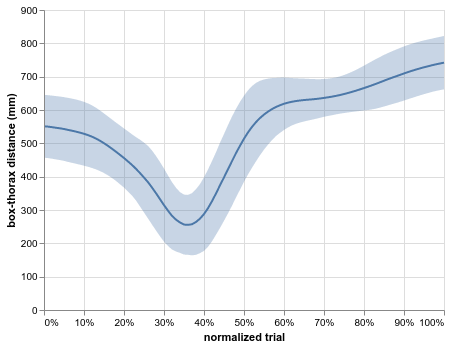

In [15]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

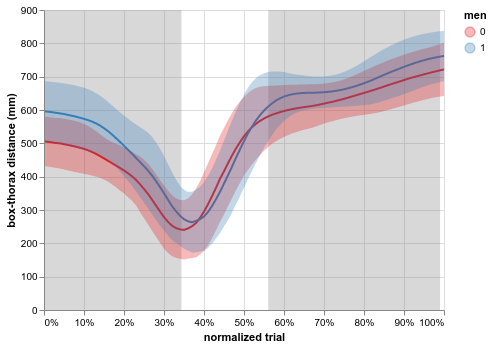

In [16]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

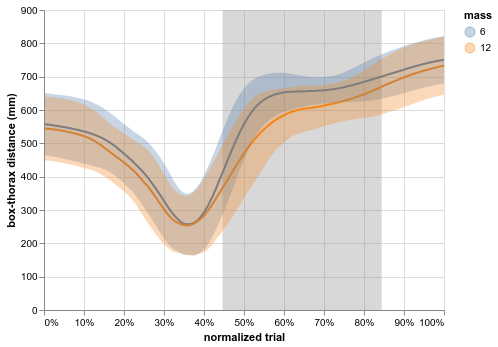

In [17]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

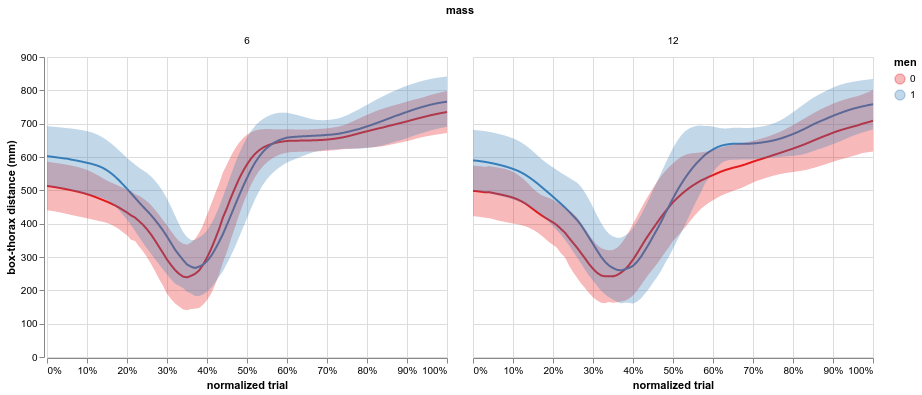

In [18]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Hip vertical displacement

In [20]:
hip_markers = [
    "ASISl_X",
    "ASISl_Y",
    "ASISl_Z",
    "ASISr_X",
    "ASISr_Y",
    "ASISr_Z",
    "PSISl_X",
    "PSISl_Y",
    "PSISl_Z",
    "PSISr_X",
    "PSISr_Y",
    "PSISr_Z",
]


def hip_normalized_displacement(x):
    hip = pd.concat(
        [x[hip_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y", "Z"]],
        axis=1,
    )
    hip_first_frame = pd.concat([hip.loc[[0]]] * hip.shape[0], ignore_index=True)
    return (
        np.sqrt(((hip - hip_first_frame) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )

In [85]:
hip_displacement = (
    pd.concat(
        [
            Markers3d.from_trc(ifile)
            .time_normalization()
            .to_dataframe()
            .pipe(hip_normalized_displacement)
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [86]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(hip_displacement)

Initial
n. participants: 40
----------
men
0    114
1    125
----------
height
2    239
----------
mass
6     120
12    119
----------
men  mass
0    6       57
     12      57
1    6       63
     12      62
----------


In [87]:
balanced_trials = random_balanced_design(
    hip_displacement, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
hip_displacement = hip_displacement.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(hip_displacement)

Balanced:
n. participants: 40
----------
men
0    114
1    114
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       57
     12      57
1    6       57
     12      57
----------


### Normalize based on particpant height

In [88]:
height = (
    pd.read_csv(conf.conf_path)
    .query("process == 1")[["participant", "height"]]
    .rename(columns={"height": "p_height"})
)

hip_displacement = hip_displacement.merge(height, on="participant", how="left").eval(
    "hip_displacement = hip_displacement / (p_height * 10)"
)

### Stats

In [89]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    hip_displacement.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

hip_displacement            \
index                                                       0.01      0.02   
filename    participant men height mass n_trial                              
VerCF6H2_1  37          0   2      6    1               0.000946  0.001196   
VerCF12H2_2 37          0   2      12   2               0.000956  0.001263   
VerCF12H2_1 37          0   2      12   1               0.000787  0.000988   
VerCF12H2_3 37          0   2      12   3               0.000778  0.000918   
VerCF6H2_2  37          0   2      6    2               0.000970  0.001101   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
VerCF6H2_1  37          0   2      6    1        0.001476  0.001528  0.001343   
VerCF12H2_2 37          0   2      12   2        0.001509  0.001646  0.001725   
VerCF12H2_1 37          0   2      12   1        0.001263  0.001523  0.001877   
VerCF12H2_3 37          0   2      12   3        0.001051  0.001212  0.001404   
VerCF6H2_2  37          0   2      6    2        0.001058  0.000927  0.001070   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
VerCF6H2_1  37          0   2      6    1        0.001662  0.002698  0.003766   
VerCF12H2_2 37          0   2      12   2        0.001860  0.002002  0.002663   
VerCF12H2_1 37          0   2      12   1        0.002319  0.002442  0.002216   
VerCF12H2_3 37          0   2      12   3        0.001683  0.002204  0.002978   
VerCF6H2_2  37          0   2      6    2        0.001577  0.002170  0.002459   

                                                                     ...  \
index                                                0.09      0.10  ...   
filename    participant men height mass n_trial                      ...   
VerCF6H2_1  37          0   2      6    1        0.005104  0.006269  ...   
VerCF12H2_2 37          0   2      12   2        0.003664  0.005298  ...   
VerCF12H2_1 37          0   2      12   1        0.001600  0.001982  ...   
VerCF12H2_3 37          0   2      12   3        0.003894  0.004677  ...   
VerCF6H2_2  37          0   2      6    2        0.002541  0.001976  ...   

                                                p_height                       \
index                                               0.91   0.92   0.93   0.94   
filename    participant men height mass n_trial                                 
VerCF6H2_1  37          0   2      6    1          164.0  164.0  164.0  164.0   
VerCF12H2_2 37          0   2      12   2          164.0  164.0  164.0  164.0   
VerCF12H2_1 37          0   2      12   1          164.0  164.0  164.0  164.0   
VerCF12H2_3 37          0   2      12   3          164.0  164.0  164.0  164.0   
VerCF6H2_2  37          0   2      6    2          164.0  164.0  164.0  164.0   

                                                                             \
index                                             0.95   0.96   0.97   0.98   
filename    participant men height mass n_trial                               
VerCF6H2_1  37          0   2      6    1        164.0  164.0  164.0  164.0   
VerCF12H2_2 37          0   2      12   2        164.0  164.0  164.0  164.0   
VerCF12H2_1 37          0   2      12   1        164.0  164.0  164.0  164.0   
VerCF12H2_3 37          0   2      12   3        164.0  164.0  164.0  164.0   
VerCF6H2_2  37          0   2      6    2        164.0  164.0  164.0  164.0   

                                                               
index                                             0.99   1.00  
filename    participant men height mass n_trial                
VerCF6H2_1  37          0   2      6    1 

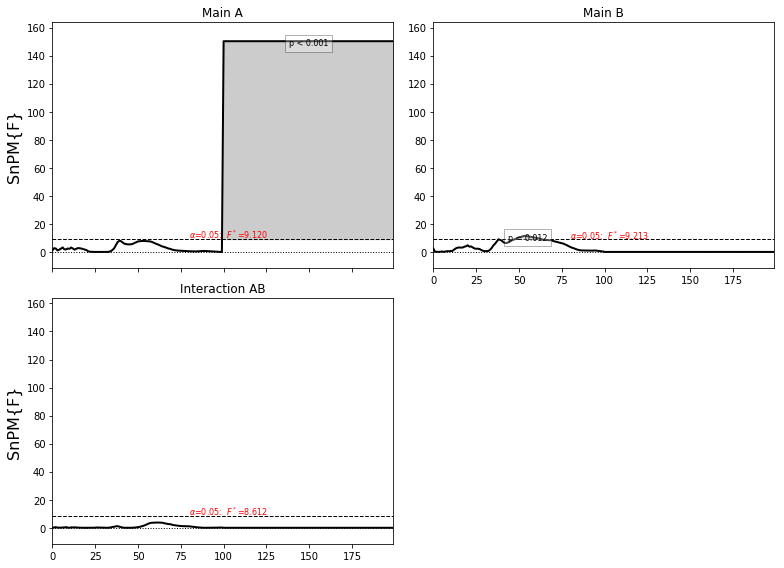

In [93]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [94]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0,0.495303,0.995
1,main mass,0.012,0.239012,0.314915


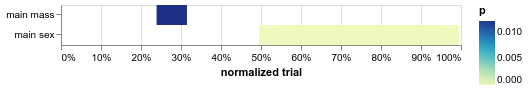

In [95]:
alt.Chart(clusters).mark_rect().encode(
    alt.X(
        "start",
        title="normalized trial",
        axis=alt.Axis(format="%"),
        scale=alt.Scale(domain=[0, 1]),
    ),
    alt.X2("end"),
    alt.Y("effect:N", title=None),
    alt.Color("p:Q"),
)

In [96]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [97]:
base = alt.Chart(hip_displacement).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(hip_displacement)",
        title="hip vertical displacement (mm)",
        axis=alt.Axis(format="%"),
    )
)
sigma = base.mark_errorband(extent="stdev").encode(
    alt.Y("hip_displacement", title=None)
)
men_scale = alt.Scale(scheme="set1")

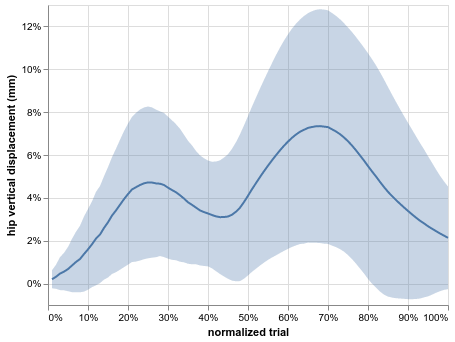

In [98]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

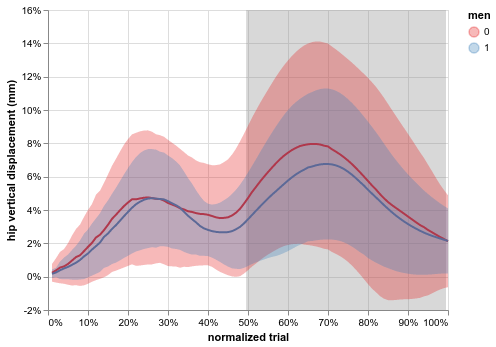

In [99]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

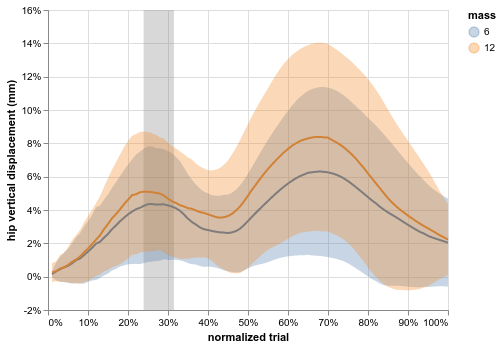

In [100]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

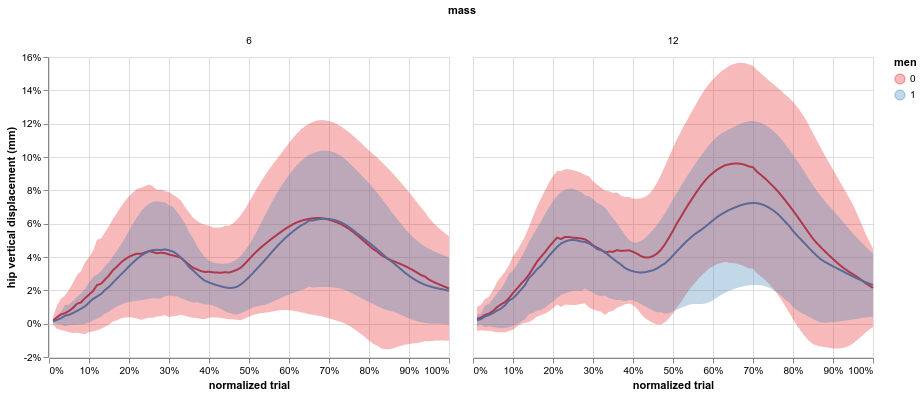

In [101]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Box inclination

In [32]:
box_incl = (
    pd.concat(
        [
            Analogs3d.from_mot(ifile)
            .time_normalization()
            .to_dataframe()[["box_rotY"]]
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob("*/1_inverse_kinematic/*.mot")
        ]
    )
    .pipe(parse_conditions, suffix="wu_")
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [46]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_incl)

Initial
n. participants: 40
----------
men
0    114
1    126
----------
height
2    240
----------
mass
6     120
12    120
----------
men  mass
0    6       57
     12      57
1    6       63
     12      63
----------


In [47]:
balanced_trials = random_balanced_design(
    box_incl, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_incl = box_incl.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_incl)

Balanced:
n. participants: 40
----------
men
0    114
1    114
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       57
     12      57
1    6       57
     12      57
----------


### Stats

In [48]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_incl.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_rotY                      \
index                                                0.00      0.01      0.02   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.071158 -0.076242 -0.085452   
VerCF12H2_3 37          0   2      12   3       -0.009264 -0.018573 -0.014573   
VerCF6H2_1  37          0   2      6    1       -0.072524 -0.062117 -0.069048   
VerCF12H2_2 37          0   2      12   2       -0.040455 -0.030781 -0.048211   
VerCF6H2_3  37          0   2      6    3       -0.065679 -0.070749 -0.076233   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.103708 -0.097241 -0.113162   
VerCF12H2_3 37          0   2      12   3       -0.004224 -0.012667 -0.013660   
VerCF6H2_1  37          0   2      6    1       -0.085744 -0.095541 -0.004661   
VerCF12H2_2 37          0   2      12   2       -0.042907 -0.051386 -0.065951   
VerCF6H2_3  37          0   2      6    3       -0.084797 -0.098515 -0.112677   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.133976 -0.146747 -0.227633   
VerCF12H2_3 37          0   2      12   3       -0.026019 -0.063381 -0.136831   
VerCF6H2_1  37          0   2      6    1       -0.024527  0.000715  0.058182   
VerCF12H2_2 37          0   2      12   2       -0.052445 -0.080458 -0.044940   
VerCF6H2_3  37          0   2      6    3       -0.158566 -0.213254 -0.313821   

                                                           ...            \
index                                                0.09  ...      0.91   
filename    participant men height mass n_trial            ...             
VerCF6H2_2  37          0   2      6    2       -0.501209  ...  0.300984   
VerCF12H2_3 37          0   2      12   3       -0.194731  ...  0.278481   
VerCF6H2_1  37          0   2      6    1        0.048257  ...  0.346287   
VerCF12H2_2 37          0   2      12   2        0.014924  ...  0.223002   
VerCF6H2_3  37          0   2      6    3       -0.402635  ...  0.359575   

                                                                               \
index                                                0.92      0.93      0.94   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.297583  0.286589  0.105273   
VerCF12H2_3 37          0   2      12   3        0.252241  0.270395  0.266160   
VerCF6H2_1  37          0   2      6    1        0.323573  0.338829  0.324097   
VerCF12H2_2 37          0   2      12   2        0.213945  0.178290  0.187304   
VerCF6H2_3  37          0   2      6    3        0.323452  0.334351  0.294551   

                                                                               \
index                                                0.95      0.96      0.97   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.277483  0.282854  0.286339   
VerCF12H2_3 37          0   2      12   3        0.250519  0.250093  0.250847   
VerCF6H2_1  37          0   2      6    1        0.299324  0.312567  0.298606   
VerCF12H2_2 37          0   2      12   2        0.183285  0.195693  0.196291   
VerCF6H2_3  37          0   2      6    3        0.344698  0.309033  0.268882   

                                                                               
index                                                0.98      0.99      1.00  
filename    participant men height 

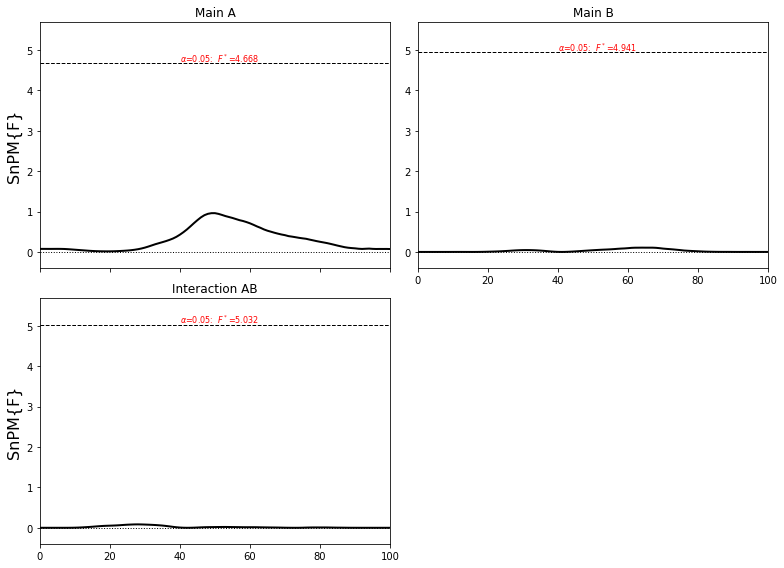

In [49]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [59]:
base = alt.Chart(box_incl).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(box_rotY)", title="box inclination (mm)"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("box_rotY", title=None))

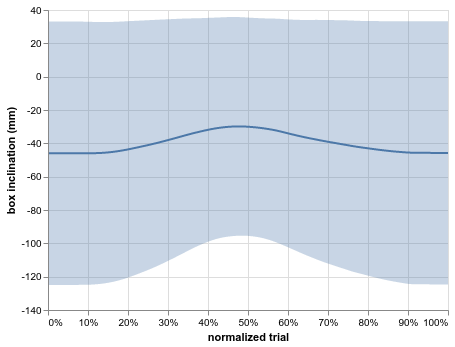

In [60]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

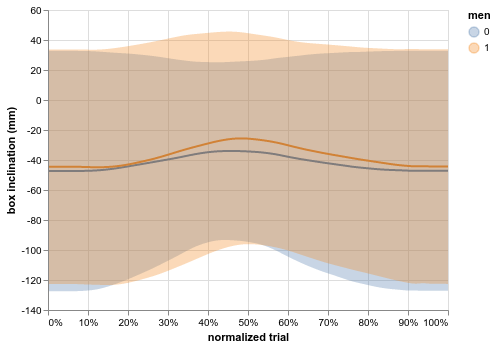

In [61]:
(mu + sigma).encode(alt.Color("men:N"))

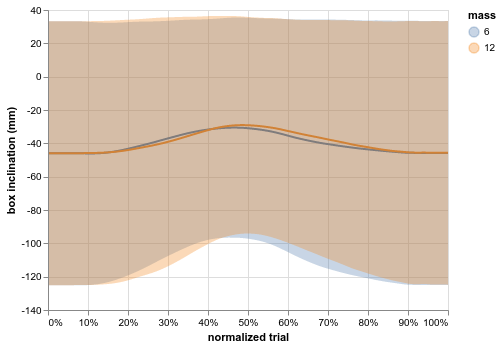

In [62]:
(mu + sigma).encode(alt.Color("mass:N"))

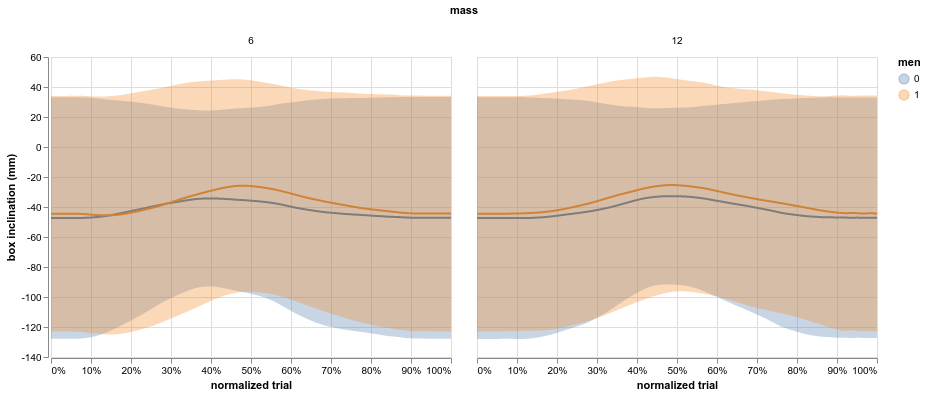

In [63]:
(mu + sigma).encode(alt.Color("men:N")).facet(column="mass")

<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >